Remaining rows after dropping NaNs in 'status': 48124
Data shape after dropping duplicates: (48124, 32)


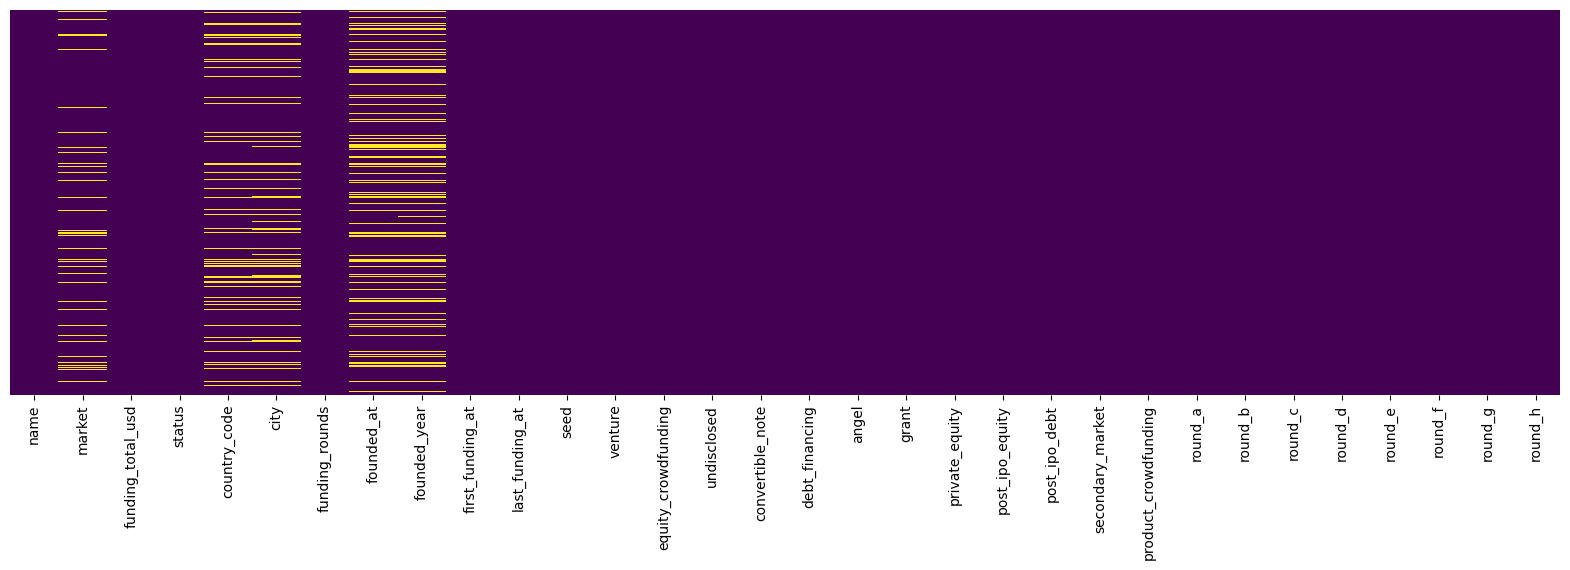

Frequency count of missing values:
0    32760
1     1888
2     9590
3     1721
4     1481
5      681
6        2
7        1
Name: count, dtype: int64
                 name         market  funding_total_usd     status  \
0            #waywire          News           1750000.0   acquired   
1  &TV Communications         Games           4000000.0  operating   
2   'Rock' Your Paper    Publishing             40000.0  operating   
3   (In)Touch Network   Electronics           1500000.0  operating   
4  -R- Ranch and Mine       Tourism             60000.0  operating   

  country_code         city  funding_rounds  founded_at  founded_year  \
0          USA     New York             1.0  2012-06-01        2012.0   
1          USA  Los Angeles             2.0         NaN           NaN   
2          EST      Tallinn             1.0  2012-10-26        2012.0   
3          GBR       London             1.0  2011-04-01        2011.0   
4          USA   Fort Worth             2.0  2014-01-01        20

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Correctly import pyplot
import seaborn as sns

# Step 1: Load the dataset
df = pd.read_csv('startup.csv', encoding='latin1')

# Step 2: Clean column names by removing spaces and converting to lowercase
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Step 3: Replace '-' with '0' in 'funding_total_usd' column and remove commas, then convert to numeric
df['funding_total_usd'] = df['funding_total_usd'].replace(' -   ', '0')  # Replace dashes with 0
df['funding_total_usd'] = df['funding_total_usd'].str.replace(',', '', regex=True).astype(float)

# Step 4: Standardize date format for 'founded_at', 'first_funding_at', and 'last_funding_at'
df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce').dt.strftime('%Y-%m-%d')
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce').dt.strftime('%Y-%m-%d')
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], errors='coerce').dt.strftime('%Y-%m-%d')

# Step 5: Drop unnecessary columns
df = df.drop(columns=['permalink', 'homepage_url', 'category_list', 'state_code', 'region', 'founded_month', 'founded_quarter'])

# Step 6: Drop rows where 'status' is NaN
df = df.dropna(subset=['status'])

# Step 7: Display the number of remaining rows after dropping NaNs in 'status'
print(f"Remaining rows after dropping NaNs in 'status': {len(df)}")

# Step 8: Drop duplicate rows
df = df.drop_duplicates()
print(f"Data shape after dropping duplicates: {df.shape}")

# Step 9: Visualize missing values using a heatmap
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

# Step 10: Count the number of missing values in each row
missing_counts = df.isnull().sum(axis=1)

# Step 11: Get the frequency count of missing values
frequency_counts = missing_counts.value_counts().sort_index()

# Step 12: Print the frequency counts for missing values
print("Frequency count of missing values:")
print(frequency_counts)

# Preview the cleaned dataset
print(df.head())

# Step 13: Drop rows with missing values in essential columns
df = df.dropna(subset=['name', 'market', 'country_code', 'city', 'first_funding_at', 'last_funding_at'])

# Display the number of remaining rows after dropping missing values in the specified columns
print(f"Remaining rows after dropping missing values in specific columns: {len(df)}")

# Ensure founded_year is numeric and founded_at is in datetime format
df['founded_year'] = pd.to_numeric(df['founded_year'], errors='coerce')
df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')

# Group by the 'market' column and impute missing values using transform
# For 'founded_year' - Impute with the median 'founded_year' for each 'market'
df['founded_year'] = df.groupby('market')['founded_year'].transform(lambda x: x.fillna(x.median()))

# For 'founded_at' - Impute with the median timestamp
df['founded_at'] = df.groupby('market')['founded_at'].transform(
    lambda x: x.fillna(pd.to_datetime(x.astype(np.int64).median(), errors='coerce'))
)

# Convert 'founded_at' back to date format
df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce').dt.date

# Check rows where 'founded_at' or 'founded_year' still have missing values
missing_values_after_imputation = df[df['founded_at'].isna() | df['founded_year'].isna()]

# Display the rows that still contain missing values
print(missing_values_after_imputation[['market', 'founded_year', 'founded_at']])

# Optional: Display the count of remaining missing values for each column
print("\nMissing values after imputation:")
print(df[['founded_at', 'founded_year']].isna().sum())

# Drop rows where 'founded_at' or 'founded_year' have missing values
df.dropna(subset=['founded_at', 'founded_year'], inplace=True)

# Optional: Check the shape of the DataFrame after dropping the rows
print("DataFrame shape after dropping rows with missing values:", df.shape)

# Save the final cleaned dataset
df.to_csv('final_cleaned_dataset.csv', index=False)